# Explore the numerical differences between PerMIT and RKZ

- results in translation of PerMIT to RKZ variables: `data/validation/variables_translation.json`

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.3, context="paper")

PATH_base = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

In [2]:
''' 
Select features
'''

target = "Conclusion_micro"
percentBoruta = 100


datasetTimepoint = "ENTRY"
fs_entry = pd.read_csv(f"{PATH_base}/results/20_featureSelection/{datasetTimepoint}/CV/{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc.txt", 
                       header=None)[0].tolist()
#print(fs_entry)

datasetTimepoint = "PRESURGERY"
fs_pre = pd.read_csv(f"{PATH_base}/results/20_featureSelection/{datasetTimepoint}/CV/{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc.txt", 
                       header=None)[0].tolist()
#print(fs_pre)

datasetTimepoint = "POSTSURGERY"
fs_post = pd.read_csv(f"{PATH_base}/results/20_featureSelection/{datasetTimepoint}/CV/{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc.txt", 
                       header=None)[0].tolist()
#print(fs_post)

datasetTimepoint = "BL"
fs_bl = pd.read_csv(f"{PATH_base}/results/20_featureSelection/{datasetTimepoint}/CV/{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc.txt", 
                       header=None)[0].tolist()
#print(fs_bl)


fs_overlap = list(set(fs_entry + fs_pre + fs_post + fs_bl))
print(fs_overlap)

['AGE', 'creatinine_preop', 'platelet_BL', 'glucose_BL', 'LOWER_ARM_ARRIVAL', 'DIABETES', 'hgb_preop', 'UPPER_ARM_ARRIVAL', 'ANOGENITAL_ARRIVAL', 'sys_bp_low_bl', 'NA_max_BL', 'creatinine_BL', 'preadmission_creatinine', 'lactate_BL', 'sample_site_1', 'SURGERY_BEFORE']


# Load High-quality dataset (216 patients)

In [3]:
df_prim = pd.read_csv("../../data/validation/raw_data/Datafile_NSTI_216primair_tavGASpredictions.csv", na_values=" ")

### recode missing measurements as missing values
na_other = {-99:np.nan,
            -98:np.nan,
            -97:np.nan,
            -96:np.nan,
            -95:np.nan,
            2:np.nan}
df_prim.replace(na_other, inplace=True)

df_prim['bodypart_adm_pres#Lower_arm'] = df_prim.loc[:,['bodypart_adm_pres#Left_Lower_arm',
                                                        'bodypart_adm_pres#Right_Lower_arm']].max(axis=1)

df_prim['bodypart_adm_pres#Upper_arm'] = df_prim.loc[:,['bodypart_adm_pres#Left_Upper_arm',
                                                        'bodypart_adm_pres#Right_Upper_arm']].max(axis=1)

''' 
encoded and only variables in ENTRY & PRE
'''
vars_val_enc = [
 'GAS_yes_no',
 'age_pres',
 'Diabetes_M',
 'surg_area_NSTI',
 'bodypart_adm_pres#Lower_arm',
 'bodypart_adm_pres#Anogenital_region',
 'bodypart_adm_pres#Upper_arm',
 'Adm_pres_Creat',
 'Adm_pres_Creat_alt',
 'Adm_pres_Hb',
 'Adm_pres_Hb_alt',
 ]


# Compare distribution: PerMIT & RKZ

- use `_alt` variables or not? 

In [21]:
# def plot_compare_bar2(var_permit, var_rkz, title=""):
#     fig, ax = plt.subplots(1,2, figsize=(6,5))
#     df_permit[var_permit].value_counts(normalize=True).plot.bar(ax=ax[0])
#     df_rkz[var_rkz].value_counts(normalize=True).plot.bar(ax=ax[1], color="green")
#     for axx in [ax[0], ax[1]]:
#         axx.set_ylim(0,1)
#         axx.bar_label(axx.containers[0], fmt='%.2f')
#         axx.set_xticklabels(["No (0)", "Yes (1)"])
#         axx.set_xlabel("")
#     ax[0].set_title("PerMIT (discovery)")
#     ax[1].set_title("RKZ (validation)")
#     ax[1].set_yticklabels("")
#     fig.suptitle(title)
#     plt.tight_layout()
#     return 


def plot_compare_bar(var_permit, var_rkz, title=""):
    fig, ax = plt.subplots(1,1, figsize=(5,5))

    tmp = pd.DataFrame(df_permit[var_permit].copy().value_counts(normalize=True)).reset_index()
    tmp["dataset"] = "PerMIT (discovery)"
    tmp2 = pd.DataFrame(df_rkz[var_rkz].copy().value_counts(normalize=True)).reset_index()
    tmp2["dataset"] = "RKZ (validation)"
    tmp.columns = ["target", 'proportion', "dataset"]
    tmp2.columns = ["target", 'proportion', "dataset"]
    tmp_plot = pd.concat([tmp, tmp2], axis=0).melt("dataset", "proportion")
    tmp_plot["xlabel"] = ["No (0)","Yes (1)","No (0)","Yes (1)"]

    sns.barplot(tmp_plot, x="xlabel", y="value", hue="dataset", ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Proportion")
    ax.set_ylim(0,1)
    ax.set_xlabel("")
    ax.legend(title="")
    plt.tight_layout()
    return  tmp_plot


def plot_compare_density_violin(var_permit, var_rkz, title="", unit=''):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    tmp = df_permit[[var_permit]].copy()   #creatinine_preop
    tmp["dataset"] = "PerMIT (discovery)"
    tmp2 = df_rkz[[var_rkz]].copy()    # Adm_pres_Creat
    tmp2["dataset"] = "RKZ (validation)"
    tmp2.columns = tmp.columns.tolist()
    tmp_plot = pd.concat([tmp, tmp2], axis=0).melt("dataset")

    sns.violinplot(data=tmp_plot, x="variable", y="value", hue="dataset", split=True, ax=ax,
                    gap=.05,inner="quart")
    
    ax.set_title(title)
    ax.set_ylabel(unit)
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.legend(title="")

    plt.tight_layout()
    return tmp_plot

In [10]:
fs_pre_target = fs_pre.copy()
fs_pre_target.append(target)

''' Permit '''
df_permit = pd.read_csv(f"{PATH_base}/results/10_preprocessed/PRESURGERY_{target}_preprocessed.csv", index_col=0)\
            .loc[:, fs_pre_target]
print(df_permit.columns)

''' GAS '''
df_rkz = df_prim.loc[:, vars_val_enc]
print(df_rkz.columns)

Index(['creatinine_preop', 'hgb_preop', 'UPPER_ARM_ARRIVAL',
       'LOWER_ARM_ARRIVAL', 'ANOGENITAL_ARRIVAL', 'DIABETES', 'SURGERY_BEFORE',
       'AGE', 'Conclusion_micro'],
      dtype='object')
Index(['GAS_yes_no', 'age_pres', 'Diabetes_M', 'surg_area_NSTI',
       'bodypart_adm_pres#Lower_arm', 'bodypart_adm_pres#Anogenital_region',
       'bodypart_adm_pres#Upper_arm', 'Adm_pres_Creat', 'Adm_pres_Creat_alt',
       'Adm_pres_Hb', 'Adm_pres_Hb_alt'],
      dtype='object')


# Table

## Binary

In [39]:
var_permit="DIABETES", 
var_rkz="Diabetes_M"

print(df_permit.loc[:, var_permit].value_counts())
print(df_permit.loc[:, var_permit].value_counts(normalize=True), "\n\n")

print(df_rkz.loc[:, var_rkz].value_counts())
print(df_rkz.loc[:, var_rkz].value_counts(normalize=True))

DIABETES
0           311
1            98
Name: count, dtype: int64
DIABETES
0           0.760391
1           0.239609
Name: proportion, dtype: float64 


Diabetes_M
0    158
1     58
Name: count, dtype: int64
Diabetes_M
0    0.731481
1    0.268519
Name: proportion, dtype: float64


## Continuous

In [48]:
var_permit="creatinine_preop" 
var_rkz="Adm_pres_Creat"

print(df_permit.loc[:, var_permit].mean(), df_permit.loc[:, var_permit].std(), "\n\n")
print(df_rkz.loc[:, var_rkz].mean(), df_rkz.loc[:, var_rkz].std())

161.17480719794344 121.34538030946973 


153.74 123.26187508409171


# Figures

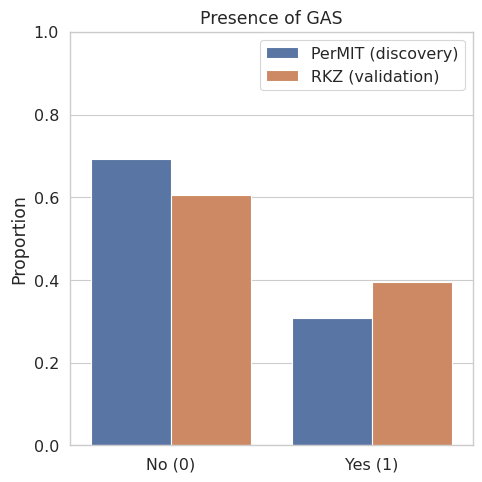

In [33]:
'''
GAS 
'''
tmp = plot_compare_bar(var_permit="Conclusion_micro", 
                var_rkz="GAS_yes_no", 
                title="Presence of GAS")

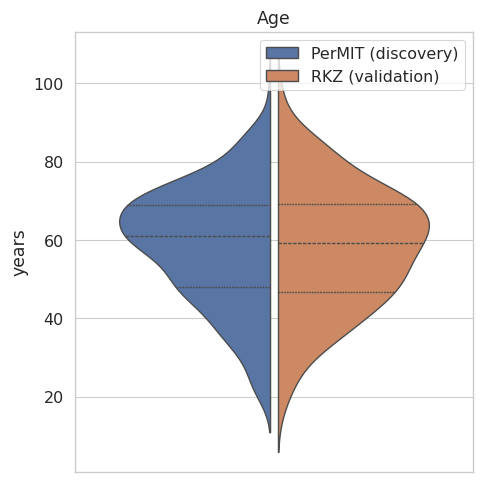

In [34]:
'''
Age
'''
tmp = plot_compare_density_violin(
    var_permit="AGE", 
    var_rkz="age_pres", 
    titletmp

#

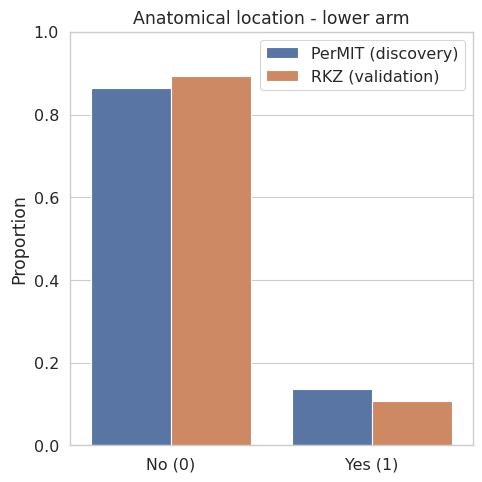

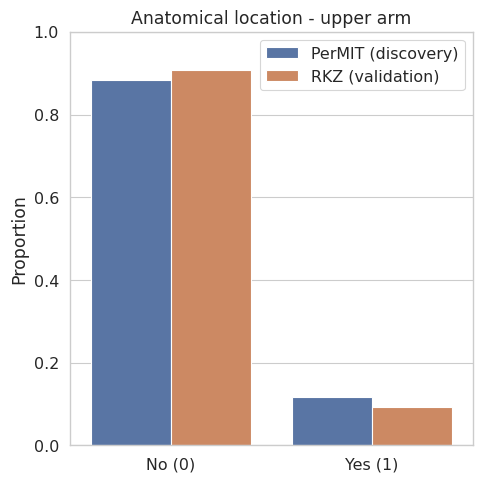

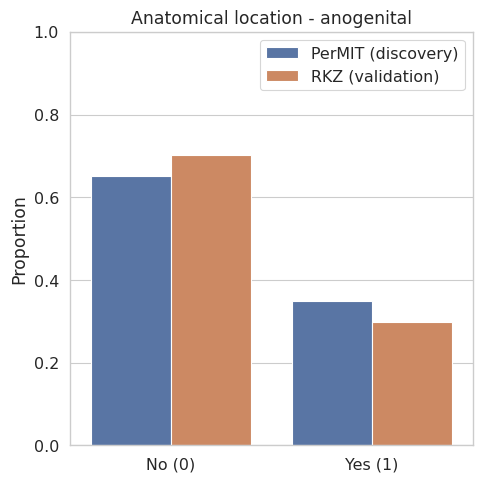

In [8]:
'''
Anatomical location 
'''
plot_compare_bar(var_permit="LOWER_ARM_ARRIVAL", 
                 var_rkz="bodypart_adm_pres#Lower_arm", 
                 title="Anatomical location - lower arm")

plot_compare_bar(var_permit="UPPER_ARM_ARRIVAL", 
                 var_rkz="bodypart_adm_pres#Upper_arm", 
                 title="Anatomical location - upper arm")

plot_compare_bar(var_permit="ANOGENITAL_ARRIVAL", 
                 var_rkz="bodypart_adm_pres#Anogenital_region", 
                 title="Anatomical location - anogenital")


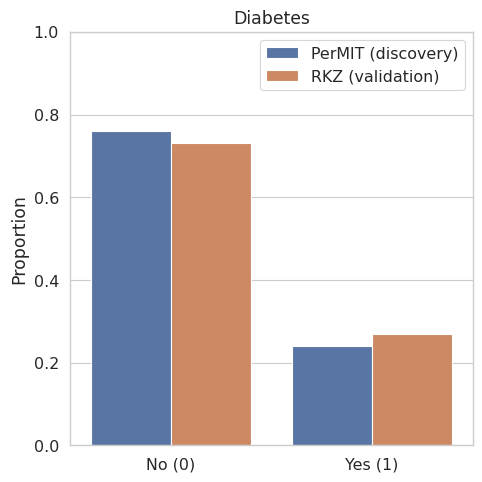

In [9]:
''' 
DIABETES
'''

plot_compare_bar(var_permit="DIABETES",
                 var_rkz="Diabetes_M", 
                 title="Diabetes")

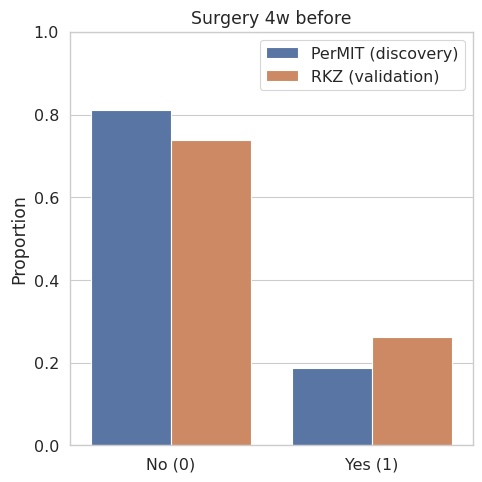

In [10]:
''' 
SURGERY_BEFORE
'''
plot_compare_bar(var_permit="SURGERY_BEFORE",
                 var_rkz="surg_area_NSTI", 
                 title="Surgery 4w before")

161.17480719794344
153.74


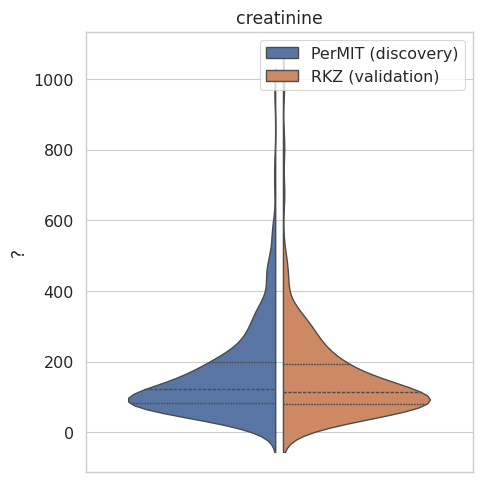

In [14]:
''' 
creatinine
'''
plot_compare_density_violin(var_permit="creatinine_preop", 
                     var_rkz="Adm_pres_Creat", 
                     title="creatinine",
                     unit="?")

print(df_permit["creatinine_preop"].mean())
#print(df_rkz["Adm_pres_Creat_alt"].mean())
print(df_rkz["Adm_pres_Creat"].mean())


11.428421188630491
12.696868686868688


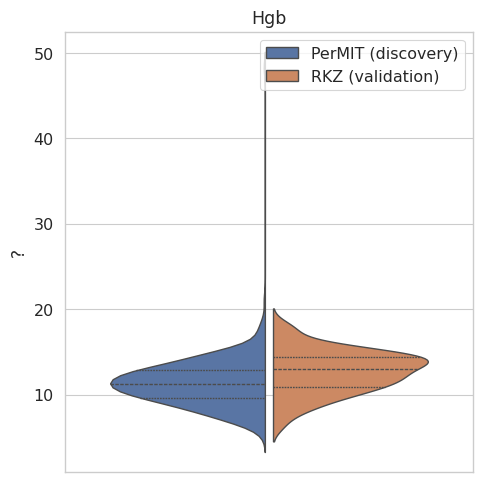

In [15]:
''' 
hgb --> conversion necessary?

Hemoglobin (mmol/L) = Hemoglobin (g/dL) × 0.6206

Permit: g/L?

'''
plot_compare_density_violin(var_permit="hgb_preop", 
                     var_rkz="Adm_pres_Hb_alt", 
                     title="Hgb", 
                     unit="?")

print(df_permit["hgb_preop"].mean())
print(df_rkz["Adm_pres_Hb_alt"].mean())
#print(df_rkz["Adm_pres_Hb"].mean())
